# **Import the Necessary Libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import ast
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error

# **Load The Train and Test Sets**

In [ ]:
"""

Input: The path to the train and test datasets.
Output: DataLoaders for the train and test datasets.
Functionality:
                - Loads the datasets from the specified paths.
                - Converts string representations of lists in the 'info_vector' and 'new_state' columns to actual lists.
                - Constructs input features (X) as a 5D vector containing coordinates and relative speed.
                - Constructs the target variable for regression (y_reg) as the relative speed at t'.
                - Constructs the target variable for classification (y_cls) as labels for LOS/NLOS/NLOSv based on the conditions specified.
                - Reshapes the input for RNN processing.

"""

def process_data(file_path, input_size = 5, seq_len = 1):
    df = pd.read_csv(file_path) # Load the dataset
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set device for PyTorch
    print(f"Processing data from {file_path} on device: {device}")

    info_vector = [ast.literal_eval(item) for item in df['info_vector']] # Convert string representation of lists to actual lists
    new_state = [ast.literal_eval(item) for item in df['new_state']] # Convert string representation of lists to actual lists

    # X: input features (5D vector: coord1[x,y], coord2[x,y], rel_speed)
    X = torch.tensor([
        list(coord1) + list(coord2) + [rel_speed]
        for coord1, coord2, rel_speed in info_vector
    ], dtype=torch.float32).to(device)  # Convert to tensor and move to device

    ################################################################################################################################################################################

    # y_reg: relative speed at t'
    y_reg = torch.tensor([ns[2] for ns in new_state], dtype=torch.float32).view(-1, 1).to(device)  # Convert to tensor and move to device

    ################################################################################################################################################################################

    # Reshape input for RNN: [N, seq_len=1, input_size]
    X_seq = X.view(-1, seq_len, input_size)

    return TensorDataset(X_seq, y_reg)  # Return TensorDataset containing input features and target variable for regression

####################################################################################################################################################################################

# Path to the train and test datasets

train_path = 'C:/Users/Vaideeswaran/Documents/ACS Project/Learning Dataset/train_urban_dataset.csv'
test_path = 'C:/Users/Vaideeswaran/Documents/ACS Project/Learning Dataset/test_urban_dataset.csv'

# Create DataLoaders
train_dataset = process_data(train_path)
test_dataset = process_data(test_path)

Processing data from C:/Users/Vaideeswaran/Documents/ACS Project/Learning Dataset/train_urban_dataset.csv on device: cuda


# **RNN**

## **Training**

cuda
Total parameters: 1056769
Trainable parameters: 1056769


 10%|█         | 1/10 [00:15<02:15, 15.05s/it]

Epoch 1 Loss:  9.928902317761562


 20%|██        | 2/10 [00:30<02:01, 15.18s/it]

Epoch 2 Loss:  3.978669892439663


 30%|███       | 3/10 [00:45<01:45, 15.10s/it]

Epoch 3 Loss:  3.1559893588157237


 40%|████      | 4/10 [01:00<01:30, 15.05s/it]

Epoch 4 Loss:  2.9573304802077622


 50%|█████     | 5/10 [01:15<01:15, 15.04s/it]

Epoch 5 Loss:  2.893719836388025


 60%|██████    | 6/10 [01:30<00:59, 14.92s/it]

Epoch 6 Loss:  2.857147160121605


 70%|███████   | 7/10 [01:44<00:44, 14.93s/it]

Epoch 7 Loss:  2.8366963073662115


 80%|████████  | 8/10 [01:59<00:29, 14.93s/it]

Epoch 8 Loss:  2.818950689205131


 90%|█████████ | 9/10 [02:14<00:14, 14.77s/it]

Epoch 9 Loss:  2.8075949011402326


100%|██████████| 10/10 [02:29<00:00, 14.91s/it]

Epoch 10 Loss:  2.7948964613289555


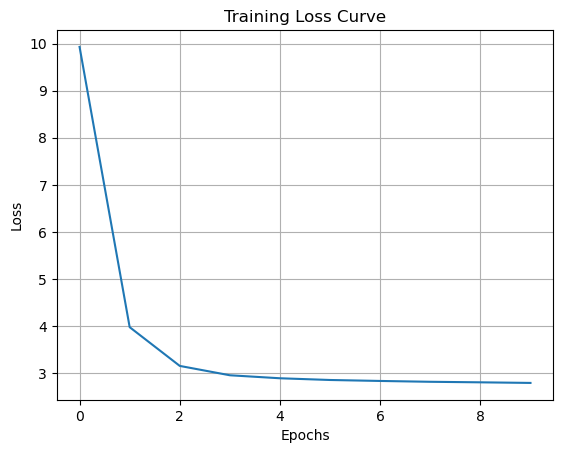

In [3]:
class RNN(nn.Module):
    def __init__(self, hidden_size, input_size = 5, output_size = 1):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.reg_head = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.ReLU()
        )

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # take the output from the last time step
        return self.reg_head(out)


# Hyperparameters

hidden_size = 1024  # Size of the hidden layer in the RNN
num_epochs = 10 # Number of epochs for training
lr = 1e-4 # Learning rate for the optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512  # Define batch size

####################################################################################################################################################################################

# Create DataLoaders for training and testing datasets

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

####################################################################################################################################################################################

# Instantiate model

model = RNN(hidden_size).to(device)
print(device)

# Total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Only trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

####################################################################################################################################################################################

optimizer = optim.Adam(model.parameters(), lr=lr)
regression_loss_fn = nn.L1Loss()  # Loss function for regression
loss_list = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    total_loss = 0.0
    for batch_x, batch_y_reg in train_loader:
        reg_out = model(batch_x)

        loss = regression_loss_fn(reg_out, batch_y_reg)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss = total_loss + loss.item()

    print("Epoch", epoch + 1, "Loss: ", total_loss / len(train_loader))
    loss_list.append(total_loss / len(train_loader))

# Save the model
torch.save(model.state_dict(), 'C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/rnn_urban.pth')

# Plot the loss curve

plt.plot(loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid()
plt.savefig('C:/Users/Vaideeswaran/Documents/ACS Project/Train Plots/rnn_urban_loss_curve.svg')
plt.show()

## **Testing**

In [4]:
model = RNN(hidden_size).to(device)
model.load_state_dict(torch.load('C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/rnn_urban.pth'))
model.eval()

prediction_list = []
target_list = []

with torch.no_grad():
    for x_batch, y_reg_batch in tqdm(test_loader, desc="Testing", unit="batch"):
        x_batch = x_batch.to(device)
        y_reg_batch = y_reg_batch.to(device)

        reg_out = model(x_batch)

        prediction_list.extend(reg_out.view(-1).cpu().numpy())
        target_list.extend(y_reg_batch.view(-1).cpu().numpy())

# Compute metrics
mae = mean_absolute_error(target_list, prediction_list)
print(f"Regression MAE: {mae:.4f}")

# Save predictions and targets to CSV
predictions_df = pd.DataFrame({
    'Predictions': prediction_list,
    'Targets': target_list,
    'Error': np.abs(np.array(prediction_list) - np.array(target_list))
})
predictions_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Performance/rnn_urban_predictions.csv', index=False)

Testing: 100%|██████████| 15444/15444 [01:03<00:00, 244.47batch/s]


Regression MAE: 1.9773


In [5]:
model = RNN(hidden_size).to(device)
model.load_state_dict(torch.load('C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/rnn_urban.pth'))
model.eval()

prediction_list_train = []
target_list_train = []

with torch.no_grad():
    for x_batch, y_reg_batch in tqdm(train_loader, desc="Testing", unit="batch"):
        x_batch = x_batch.to(device)
        y_reg_batch = y_reg_batch.to(device)

        reg_out = model(x_batch)

        prediction_list_train.extend(reg_out.view(-1).cpu().numpy())
        target_list_train.extend(y_reg_batch.view(-1).cpu().numpy())

# Compute metrics
mae = mean_absolute_error(target_list_train, prediction_list_train)
print(f"Regression MAE: {mae:.4f}")

# Save predictions and targets to CSV
predictions_df = pd.DataFrame({
    'Predictions': prediction_list_train,
    'Targets': target_list_train,
    'Error': np.abs(np.array(prediction_list_train) - np.array(target_list_train))
})
predictions_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Performance/rnn_urban_predictions_train.csv', index=False)

Testing: 100%|██████████| 2930/2930 [00:11<00:00, 246.90batch/s]


Regression MAE: 2.7975


# **LSTM**

## **Training**

cuda
Total parameters: 1063425
Trainable parameters: 1063425


 10%|█         | 1/10 [00:15<02:20, 15.58s/it]

Epoch 1 Loss:  14.255149902093125


 20%|██        | 2/10 [00:31<02:07, 15.96s/it]

Epoch 2 Loss:  5.3821222424914


 30%|███       | 3/10 [00:49<01:58, 16.93s/it]

Epoch 3 Loss:  4.302618995908991


 40%|████      | 4/10 [01:07<01:44, 17.35s/it]

Epoch 4 Loss:  3.52365902357134


 50%|█████     | 5/10 [01:25<01:27, 17.58s/it]

Epoch 5 Loss:  3.0732691887295696


 60%|██████    | 6/10 [01:45<01:12, 18.21s/it]

Epoch 6 Loss:  2.88472027034076


 70%|███████   | 7/10 [02:01<00:53, 17.69s/it]

Epoch 7 Loss:  2.808619409941976


 80%|████████  | 8/10 [02:17<00:34, 17.16s/it]

Epoch 8 Loss:  2.7682633699410606


 90%|█████████ | 9/10 [02:34<00:16, 16.99s/it]

Epoch 9 Loss:  2.750493832456374


100%|██████████| 10/10 [02:50<00:00, 17.08s/it]

Epoch 10 Loss:  2.7384361721549833


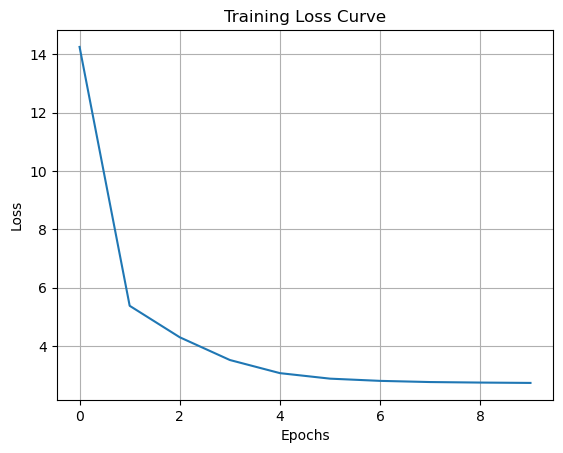

In [6]:
class LSTM(nn.Module):
    def __init__(self, hidden_size, input_size = 5, output_size = 1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.reg_head = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = out[:, -1, :]
        reg_out = self.reg_head(out)
        return reg_out

# Hyperparameters

hidden_size = 512
num_epochs = 10
lr = 1e-4 # Learning rate for the optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512  # Define batch size

####################################################################################################################################################################################

# Create DataLoaders for training and testing datasets

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)


####################################################################################################################################################################################

# Instantiate model

model = LSTM(hidden_size).to(device)
print(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
regression_loss_fn = nn.L1Loss()  # Loss function for regression

# Total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Only trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

####################################################################################################################################################################################

loss_list = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    total_loss = 0.0
    for batch_x, batch_y_reg in train_loader:
        reg_out = model(batch_x)

        loss = regression_loss_fn(reg_out, batch_y_reg)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss = total_loss + loss.item()
    print("Epoch", epoch + 1, "Loss: ", total_loss / len(train_loader))
    loss_list.append(total_loss / len(train_loader))

# Save the model
torch.save(model.state_dict(), 'C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/lstm_urban.pth')

# Plot the loss curve
plt.plot(loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid()
plt.savefig('C:/Users/Vaideeswaran/Documents/ACS Project/Train Plots/lstm_urban_loss_curve.svg')
plt.show()

## **Testing**

In [7]:
model = LSTM(hidden_size).to(device)
model.load_state_dict(torch.load('C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/lstm_urban.pth'))
model.eval()

all_preds_reg = []
all_targets_reg = []

with torch.no_grad():
    for x_batch, y_reg_batch in tqdm(test_loader, desc="Testing", unit="batch"):
        x_batch = x_batch.to(device)
        y_reg_batch = y_reg_batch.to(device)

        reg_out = model(x_batch)

        # Collect predictions and targets

        all_preds_reg.extend(reg_out.view(-1).cpu().numpy())
        all_targets_reg.extend(y_reg_batch.view(-1).cpu().numpy())

# Compute metrics
mae = mean_absolute_error(all_targets_reg, all_preds_reg)

print(f"\nTest Results:")
print(f"Regression MAE: {mae:.4f}")

# Save predictions and targets to CSV
predictions_df = pd.DataFrame({
    'Predictions': all_preds_reg,
    'Targets': all_targets_reg,
    'Error': np.abs(np.array(all_preds_reg) - np.array(all_targets_reg))
})
predictions_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Performance/lstm_urban_predictions.csv', index=False)

Testing: 100%|██████████| 15444/15444 [01:09<00:00, 222.44batch/s]



Test Results:
Regression MAE: 1.9643


In [8]:
model = LSTM(hidden_size).to(device)
model.load_state_dict(torch.load('C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/lstm_urban.pth'))
model.eval()

prediction_list_train = []
target_list_train = []

with torch.no_grad():
    for x_batch, y_reg_batch in tqdm(train_loader, desc="Testing", unit="batch"):
        x_batch = x_batch.to(device)
        y_reg_batch = y_reg_batch.to(device)

        reg_out = model(x_batch)

        prediction_list_train.extend(reg_out.view(-1).cpu().numpy())
        target_list_train.extend(y_reg_batch.view(-1).cpu().numpy())

# Compute metrics
mae = mean_absolute_error(target_list_train, prediction_list_train)
print(f"Regression MAE: {mae:.4f}")

# Save predictions and targets to CSV
predictions_df = pd.DataFrame({
    'Predictions': prediction_list_train,
    'Targets': target_list_train,
    'Error': np.abs(np.array(prediction_list_train) - np.array(target_list_train))
})
predictions_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Performance/lstm_urban_predictions_train.csv', index=False)

Testing: 100%|██████████| 2930/2930 [00:12<00:00, 238.87batch/s]


Regression MAE: 2.7649


# **GRU**

## **Training**

cuda
Total parameters: 1093201
Trainable parameters: 1093201


 10%|█         | 1/10 [00:19<02:52, 19.17s/it]

Epoch 1 Loss:  11.830307531194068


 20%|██        | 2/10 [00:40<02:42, 20.37s/it]

Epoch 2 Loss:  5.081341979324614


 30%|███       | 3/10 [00:59<02:19, 19.87s/it]

Epoch 3 Loss:  4.193103636653757


 40%|████      | 4/10 [01:18<01:55, 19.27s/it]

Epoch 4 Loss:  3.5558259690987777


 50%|█████     | 5/10 [01:37<01:36, 19.35s/it]

Epoch 5 Loss:  3.1799745198402793


 60%|██████    | 6/10 [01:55<01:15, 18.96s/it]

Epoch 6 Loss:  2.977109377620163


 70%|███████   | 7/10 [02:13<00:55, 18.52s/it]

Epoch 7 Loss:  2.8879522736975765


 80%|████████  | 8/10 [02:31<00:36, 18.36s/it]

Epoch 8 Loss:  2.8394323560971855


 90%|█████████ | 9/10 [02:49<00:18, 18.17s/it]

Epoch 9 Loss:  2.8025280919905002


100%|██████████| 10/10 [03:06<00:00, 18.70s/it]

Epoch 10 Loss:  2.7864641580158533


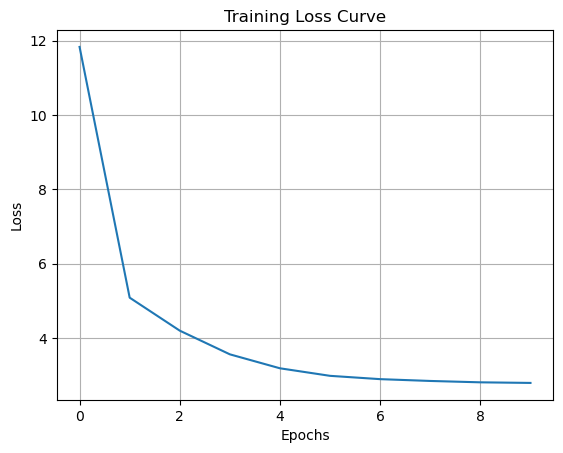

In [10]:
class GRU(nn.Module):
    def __init__(self, hidden_size, input_size = 5, output_size = 1):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.reg_head = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, hn = self.gru(x)
        out = out[:, -1, :]
        reg_out = self.reg_head(out)
        return reg_out

# Hyperparameters

hidden_size = 600
num_epochs = 10
lr = 1e-4 # Learning rate for the optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512  # Define batch size

####################################################################################################################################################################################

# Create DataLoaders for training and testing datasets

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

####################################################################################################################################################################################

# Instantiate model

model = GRU(hidden_size).to(device)
print(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
regression_loss_fn = nn.L1Loss()  # Loss function for regression

# Total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Only trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

####################################################################################################################################################################################

loss_list = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    total_loss = 0.0
    for batch_x, batch_y_reg in train_loader:
        reg_out = model(batch_x)

        loss = regression_loss_fn(reg_out, batch_y_reg)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss = total_loss+ loss.item()
    print("Epoch", epoch + 1, "Loss: ", total_loss / len(train_loader))
    loss_list.append(total_loss / len(train_loader))

# Save the model
torch.save(model.state_dict(), 'C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/gru_urban.pth')

# Plot the loss curve

plt.plot(loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid()
plt.savefig('C:/Users/Vaideeswaran/Documents/ACS Project/Train Plots/gru_urban_loss_curve.svg')
plt.show()

## **Testing**

In [11]:
model = GRU(hidden_size).to(device)
model.load_state_dict(torch.load('C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/gru_urban.pth'))
model.eval()

all_preds_reg = []
all_targets_reg = []

with torch.no_grad():
    for x_batch, y_reg_batch in tqdm(test_loader, desc="Testing", unit="batch"):
        x_batch = x_batch.to(device)
        y_reg_batch = y_reg_batch.to(device)

        reg_out = model(x_batch)

        # Collect predictions and targets

        all_preds_reg.extend(reg_out.view(-1).cpu().numpy())
        all_targets_reg.extend(y_reg_batch.view(-1).cpu().numpy())

# Compute metrics
mae = mean_absolute_error(all_targets_reg, all_preds_reg)

print(f"\nTest Results:")
print(f"Regression MAE: {mae:.4f}")
# Save predictions and targets to CSV
predictions_df = pd.DataFrame({
    'Predictions': all_preds_reg,
    'Targets': all_targets_reg,
    'Error': np.abs(np.array(all_preds_reg) - np.array(all_targets_reg))
})
predictions_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Performance/gru_urban_predictions.csv', index=False)

Testing: 100%|██████████| 15444/15444 [01:11<00:00, 215.92batch/s]



Test Results:
Regression MAE: 1.9447


In [12]:
model = GRU(hidden_size).to(device)
model.load_state_dict(torch.load('C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/gru_urban.pth'))
model.eval()

prediction_list_train = []
target_list_train = []

with torch.no_grad():
    for x_batch, y_reg_batch in tqdm(train_loader, desc="Testing", unit="batch"):
        x_batch = x_batch.to(device)
        y_reg_batch = y_reg_batch.to(device)

        reg_out = model(x_batch)

        prediction_list_train.extend(reg_out.view(-1).cpu().numpy())
        target_list_train.extend(y_reg_batch.view(-1).cpu().numpy())

# Compute metrics
mae = mean_absolute_error(target_list_train, prediction_list_train)
print(f"Regression MAE: {mae:.4f}")

# Save predictions and targets to CSV
predictions_df = pd.DataFrame({
    'Predictions': prediction_list_train,
    'Targets': target_list_train,
    'Error': np.abs(np.array(prediction_list_train) - np.array(target_list_train))
})
predictions_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Performance/gru_urban_predictions_train.csv', index=False)

Testing: 100%|██████████| 2930/2930 [00:13<00:00, 220.50batch/s]


Regression MAE: 2.7536


# **Transformer**

## **Training**

cuda
Total parameters: 1125057
Trainable parameters: 1125057


 10%|█         | 1/10 [01:10<10:31, 70.14s/it]

Epoch 1 Loss:  18.646903218140782


 20%|██        | 2/10 [02:17<09:08, 68.62s/it]

Epoch 2 Loss:  5.728085737301628


 30%|███       | 3/10 [03:28<08:08, 69.73s/it]

Epoch 3 Loss:  5.030200883491861


 40%|████      | 4/10 [04:36<06:52, 68.76s/it]

Epoch 4 Loss:  4.657923722165436


 50%|█████     | 5/10 [05:48<05:50, 70.13s/it]

Epoch 5 Loss:  4.3938633909404485


 60%|██████    | 6/10 [07:05<04:49, 72.49s/it]

Epoch 6 Loss:  4.150505402551983


 70%|███████   | 7/10 [08:20<03:39, 73.29s/it]

Epoch 7 Loss:  3.79177083932499


 80%|████████  | 8/10 [09:35<02:27, 73.76s/it]

Epoch 8 Loss:  3.4643595395641524


 90%|█████████ | 9/10 [11:16<01:22, 82.26s/it]

Epoch 9 Loss:  3.263295703109214


100%|██████████| 10/10 [12:27<00:00, 74.73s/it]

Epoch 10 Loss:  3.1496146125598163


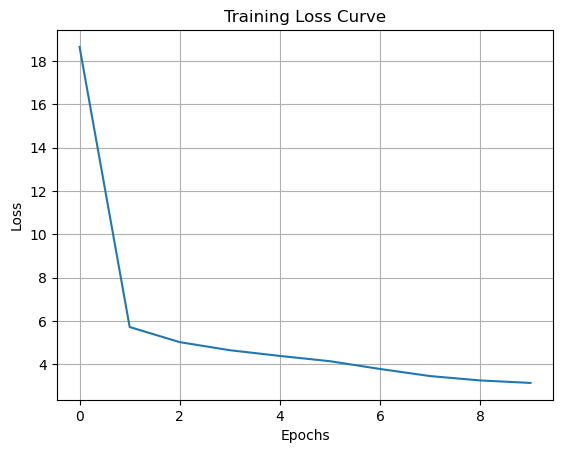

In [15]:
class Transformer(nn.Module):
    def __init__(self, hidden_size, num_heads, num_layers, input_size = 5, output_size = 1, dropout=0.1):
        super(Transformer, self).__init__()

        self.input_proj = nn.Linear(input_size, hidden_size)  # project input to model dim
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.reg_head = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.input_proj(x)                     # (batch, seq_len, hidden)
        x = self.transformer_encoder(x)            # (batch, seq_len, hidden)
        x = x[:, -1, :]                            # take last time step
        reg_out = self.reg_head(x)
        return reg_out

# Hyperparameters

hidden_size = 64
num_heads = 4
num_layers = 4
num_epochs = 10
lr = 1e-4 # Learning rate for the optimizer
batch_size = 256  # Define batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

####################################################################################################################################################################################

# Create DataLoaders for training and testing datasets

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

####################################################################################################################################################################################

# Instantiate model

model = Transformer(hidden_size, num_heads, num_layers).to(device)
print(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
regression_loss_fn = nn.L1Loss()  # Loss function for regression

# Total number of parameters

total_params = sum(p.numel() for p in model.parameters())

# Only trainable parameters

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

####################################################################################################################################################################################

loss_list = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    total_loss = 0.0
    for batch_x, batch_y_reg in train_loader:
        
        reg_out = model(batch_x)

        loss = regression_loss_fn(reg_out, batch_y_reg)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss = total_loss + loss.item()
    print("Epoch", epoch + 1, "Loss: ", total_loss / len(train_loader))
    loss_list.append(total_loss / len(train_loader))

# Save the model
torch.save(model.state_dict(), 'C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/transformer_urban.pth')

# Plot the loss curve

plt.plot(loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid()
plt.savefig('C:/Users/Vaideeswaran/Documents/ACS Project/Train Plots/transformer_urban_loss_curve.svg')
plt.show()

## **Testing**

In [16]:
model = Transformer(hidden_size, num_heads, num_layers).to(device)
model.load_state_dict(torch.load('C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/transformer_urban.pth'))
model.eval()

all_preds_reg = []
all_targets_reg = []

with torch.no_grad():
    for x_batch, y_reg_batch in tqdm(test_loader, desc="Testing", unit="batch"):
        x_batch = x_batch.to(device)
        y_reg_batch = y_reg_batch.to(device)

        reg_out = model(x_batch)

        # Collect predictions and targets

        all_preds_reg.extend(reg_out.view(-1).cpu().numpy())
        all_targets_reg.extend(y_reg_batch.view(-1).cpu().numpy())

# Compute metrics
mae = mean_absolute_error(all_targets_reg, all_preds_reg)

print(f"\nTest Results:")
print(f"Regression MAE: {mae:.4f}")

# Save predictions and targets to CSV
predictions_df = pd.DataFrame({
    'Predictions': all_preds_reg,
    'Targets': all_targets_reg,
    'Error': np.abs(np.array(all_preds_reg) - np.array(all_targets_reg))
})
predictions_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Performance/transformer_urban_predictions.csv', index=False)

Testing: 100%|██████████| 30888/30888 [02:10<00:00, 237.30batch/s]



Test Results:
Regression MAE: 2.2052


In [17]:
model = Transformer(hidden_size, num_heads, num_layers).to(device)
model.load_state_dict(torch.load('C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/transformer_urban.pth'))
model.eval()

prediction_list_train = []
target_list_train = []

with torch.no_grad():
    for x_batch, y_reg_batch in tqdm(train_loader, desc="Testing", unit="batch"):
        x_batch = x_batch.to(device)
        y_reg_batch = y_reg_batch.to(device)

        reg_out = model(x_batch)

        prediction_list_train.extend(reg_out.view(-1).cpu().numpy())
        target_list_train.extend(y_reg_batch.view(-1).cpu().numpy())

# Compute metrics
mae = mean_absolute_error(target_list_train, prediction_list_train)
print(f"Regression MAE: {mae:.4f}")

# Save predictions and targets to CSV
predictions_df = pd.DataFrame({
    'Predictions': prediction_list_train,
    'Targets': target_list_train,
    'Error': np.abs(np.array(prediction_list_train) - np.array(target_list_train))
})
predictions_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Performance/transformer_urban_predictions_train.csv', index=False)

Testing: 100%|██████████| 5860/5860 [00:24<00:00, 237.92batch/s]


Regression MAE: 3.1651


In [46]:
all_targets_reg = []

with torch.no_grad():
    for x_batch, y_reg_batch in tqdm(test_loader, desc="Testing", unit="batch"):
        all_targets_reg.extend(y_reg_batch.view(-1).cpu().numpy())
mean_target = np.mean(all_targets_reg)
baseline_mae = np.mean(np.abs(all_targets_reg - mean_target))
print(f'Baseline (mean predictor) MSE: {baseline_mae:.4f}')

Testing: 100%|██████████| 15899/15899 [01:13<00:00, 216.40batch/s]


Baseline (mean predictor) MSE: 25.0520
